# Desicion Tree Regression

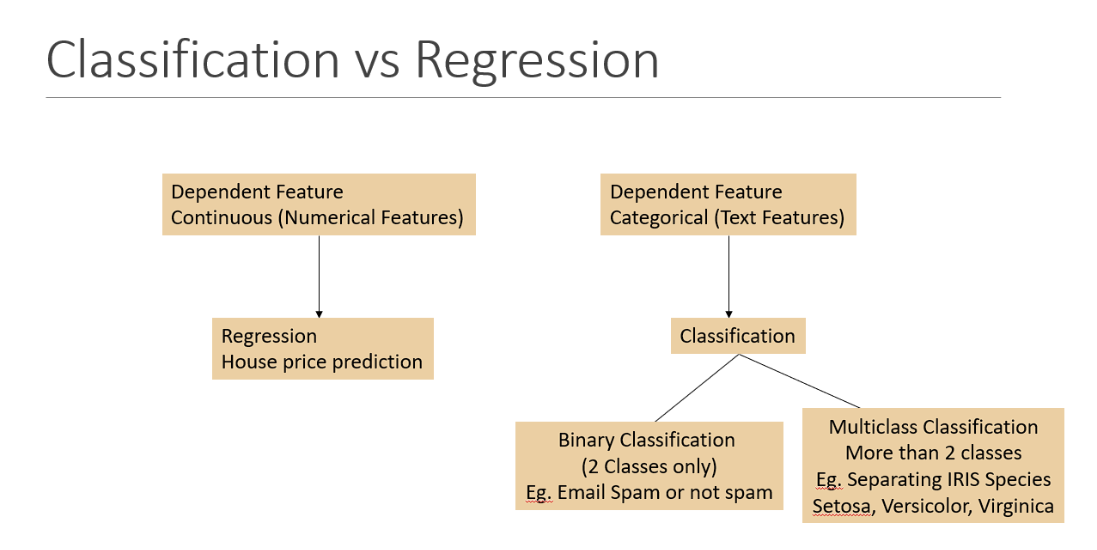

### Read the dataset

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('50_Startups.csv')
df.head()

,RND,ADMIN,MKT,STATE,PROFIT
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RND     50 non-null     float64
 1   ADMIN   50 non-null     float64
 2   MKT     50 non-null     float64
 3   STATE   50 non-null     object 
 4   PROFIT  50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


### Check missing values in dataframe

In [4]:
df.isna().sum()

RND       0
ADMIN     0
MKT       0
STATE     0
PROFIT    0
dtype: int64

### Separate X and Y in dataframe
PROFIT ~ Remaining features

In [5]:
X = df.drop(columns=['PROFIT'])
Y = df[['PROFIT']]

In [6]:
X.head()

,RND,ADMIN,MKT,STATE
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


In [7]:
Y.head()

,PROFIT
0,192261.83
1,191792.06
2,191050.39
3,182901.99
4,166187.94


### Separate cat and con for X features

In [8]:
cat = list(X.columns[X.dtypes=='object'])
con = list(X.columns[X.dtypes!='object'])

In [9]:
cat

['STATE']

In [10]:
con

['RND', 'ADMIN', 'MKT']

### Create Scikit learn pipelines

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [14]:
# Num Pipeline
num_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                           ('scaler',StandardScaler())])

# Cat Pipeline
cat_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='most_frequent')),
                           ('ohe',OneHotEncoder(handle_unknown='ignore'))])

# Combine both pipelines
pre = ColumnTransformer([('num',num_pipe,con),
                         ('cat',cat_pipe,cat)])

In [15]:
# Fit Transform the data
X_pre = pre.fit_transform(X)
X_pre[0:5]

array([[ 2.01641149,  0.56075291,  2.15394309,  0.        ,  0.        ,
         1.        ],
       [ 1.95586034,  1.08280658,  1.9236004 ,  1.        ,  0.        ,
         0.        ],
       [ 1.75436374, -0.72825703,  1.62652767,  0.        ,  1.        ,
         0.        ],
       [ 1.55478369, -0.09636463,  1.42221024,  0.        ,  0.        ,
         1.        ],
       [ 1.5049372 , -1.07991935,  1.28152771,  0.        ,  1.        ,
         0.        ]])

In [16]:
# Column Names
cols = pre.get_feature_names_out()

In [17]:
cols

array(['num__RND', 'num__ADMIN', 'num__MKT', 'cat__STATE_California',
       'cat__STATE_Florida', 'cat__STATE_New York'], dtype=object)

In [18]:
df['STATE'].unique()

array(['New York', 'California', 'Florida'], dtype=object)

In [19]:
X_pre = pd.DataFrame(X_pre, columns=cols)
X_pre.head()

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,2.016411,0.560753,2.153943,0.0,0.0,1.0
1,1.955860,1.082807,1.923600,1.0,0.0,0.0
2,1.754364,-0.728257,1.626528,0.0,1.0,0.0
3,1.554784,-0.096365,1.422210,0.0,0.0,1.0
4,1.504937,-1.079919,1.281528,0.0,1.0,0.0


# Train Test split

In [20]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_pre, Y , test_size=0.2, random_state=21)

In [22]:
xtrain.shape

(40, 6)

In [23]:
xtest.shape

(10, 6)

### Create a model
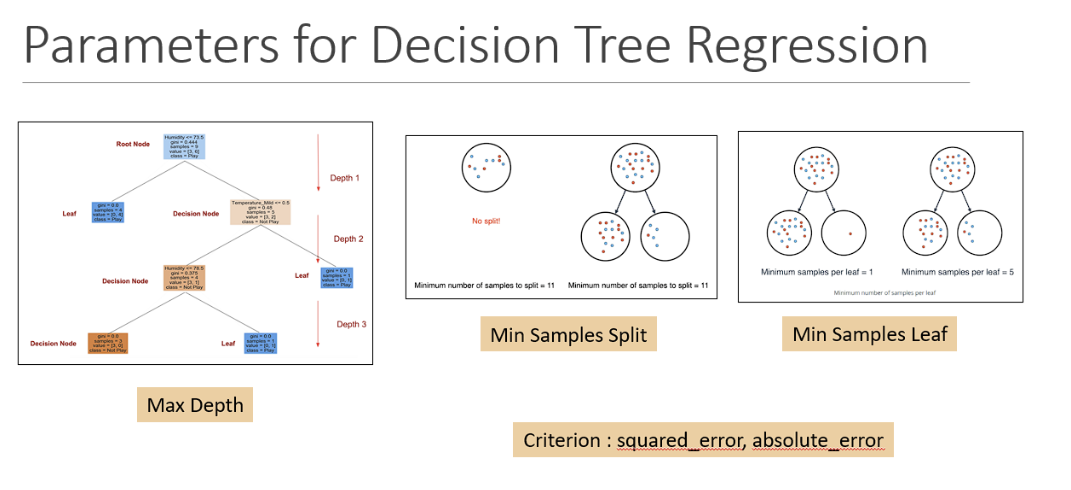

In [24]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2, min_samples_split=5, min_samples_leaf=7, criterion='absolute_error')
model.fit(xtrain, ytrain)

DecisionTreeRegressor(criterion='absolute_error', max_depth=2,
                      min_samples_leaf=7, min_samples_split=5)

In [25]:
# R2 score in training 
model.score(xtrain, ytrain)

0.7701981910547073

In [26]:
# R2 score in testing
model.score(xtest, ytest)

0.7651064857418374

### Hyperparameter tuning with GridSearchCV

In [29]:
params = {'max_depth':[2,3,4,5,6,7,8,9,10,11,12],
          'min_samples_split':[2,3,4,5,6,7,8,9,10],
          'min_samples_leaf':[5,6,7,8,9],
          'criterion':['squared_error','absolute_error']}


In [30]:
from sklearn.model_selection import GridSearchCV
dtr = DecisionTreeRegressor()
gscv = GridSearchCV(dtr, param_grid=params, cv=5, scoring='neg_root_mean_squared_error')
gscv.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_samples_leaf': [5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [31]:
gscv.best_params_

{'criterion': 'absolute_error',
 'max_depth': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [32]:
gscv.best_score_

-19207.56763914441

In [33]:
best_dtr = gscv.best_estimator_
best_dtr

DecisionTreeRegressor(criterion='absolute_error', max_depth=3,
                      min_samples_leaf=5)

In [34]:
best_dtr.score(xtrain,ytrain)

0.9170132779190516

In [35]:
best_dtr.score(xtest,ytest)

0.9142766438713301

### Predicting train and test split

In [36]:
ypred_tr = best_dtr.predict(xtrain)
ypred_ts = best_dtr.predict(xtest)

In [37]:
ypred_tr[0:5]

array([100471.115, 120625.445, 120625.445, 145190.675, 100471.115])

In [38]:
ytrain.head()

,PROFIT
30,99937.59
21,111313.02
19,122776.86
11,144259.40
22,110352.25


In [39]:
ypred_ts[0:5]

array([145190.675,  79622.835,  49490.75 , 100471.115, 145190.675])

In [40]:
ytest.head()

,PROFIT
7,155752.60
44,65200.33
43,69758.98
25,107404.34
14,132602.65


### Plotting Regression tree

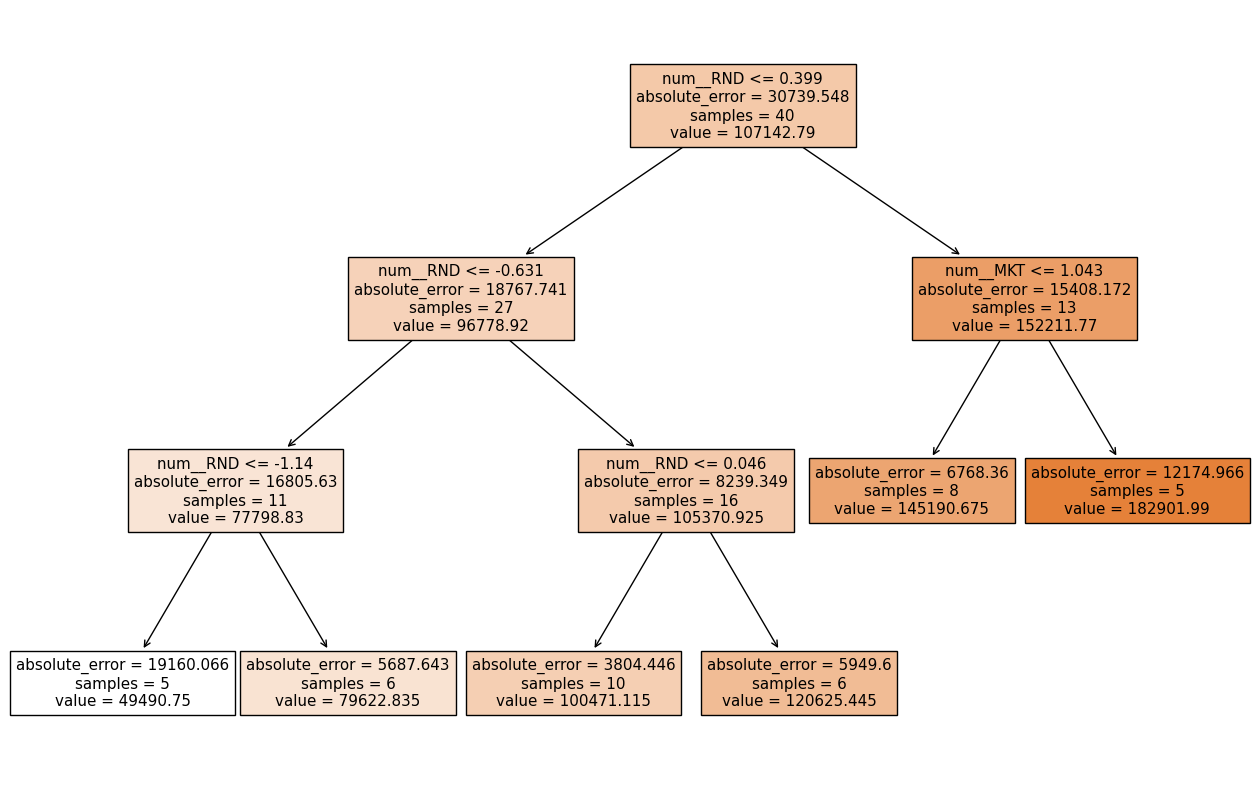

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(16,10))
plot_tree(best_dtr, feature_names=list(xtrain.columns), filled=True)
plt.show()

### Evaluate the model

In [43]:
from functions import evaluate_model

In [44]:
evaluate_model(xtrain, ytrain, xtest, ytest, best_dtr)

Training results :

MSE : 128181476.84
RMSE : 11321.73
MAE : 7967.25
R2 : 0.92

Testing results :

MSE : 152137257.91
RMSE : 12334.39
MAE : 11092.41
R2 : 0.91


### Predicting PROFIT for new startups

In [45]:
X.columns

Index(['RND', 'ADMIN', 'MKT', 'STATE'], dtype='object')

In [46]:
xnew = {'RND':[160000],
        'ADMIN':[200000],
        'MKT':[100000],
        'STATE':['New York']}
xnew = pd.DataFrame(xnew)
xnew

,RND,ADMIN,MKT,STATE
0,160000,200000,100000,New York


In [47]:
xnew_pre = pre.transform(xnew)
xnew_pre

array([[ 1.89869379,  2.83583667, -0.9170987 ,  0.        ,  0.        ,
         1.        ]])

In [48]:
xnew_pre = pd.DataFrame(xnew_pre, columns=cols)
xnew_pre

,num__RND,num__ADMIN,num__MKT,cat__STATE_California,cat__STATE_Florida,cat__STATE_New York
0,1.898694,2.835837,-0.917099,0.0,0.0,1.0


In [49]:
pred = best_dtr.predict(xnew_pre)
pred

array([145190.675])